 
# Leasing Price Predictor
**Data Science Lab**
  - Tobias Ponesch
  - Sina Haghgoo
  - Finnian John Dempsey
  - Adrian Lehrner
---

## Libraries

In [3]:
import pandas as pd
import numpy as np

import pickle
#from compress_pickle import dump, load
import warnings
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#!pip install --upgrade seaborn

***

## Import the dataset

In [5]:
df = pd.read_excel('data/dataset_2023.xlsx')
df = df.drop('Unnamed: 0', axis = 1)
df

,brand_name,model_name,milage,first_registration,duration,gear,monthly_fee,emission_value,consumption,horsepower,kilowatts,fuel_type
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [6]:
#Enter the actual column names
brand = "brand_name"
model = "model_name"
milage = "milage"
registration = "first_registration"
duration = "duration"
gear = "gear"
fee = "monthly_fee"
emission = "emission_value"
consumption = "consumption"
horsepower = "horsepower"
kilowatts = "kilowatts"
fuel = "fuel_type"

rename_columns = {
    brand:"brand",
    model:"model",
    milage:"milage",
    registration:"registration",
    duration:"duration",
    gear:"gear",
    fee:"fee",
    emission:"emission",
    consumption:"consumption",
    horsepower:"horsepower",
    kilowatts:"kilowatts",
    fuel:"fuel"
}

df = df.rename(columns=rename_columns)
df

,brand,model,milage,registration,duration,gear,fee,emission,consumption,horsepower,kilowatts,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [7]:
SEED = 2023
TARGET_name = "fee"
FEATURE_names = df.drop(TARGET_name, axis=1).columns

***

## First Preprocessing

In [8]:
class CalculateAge(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass
    
    def transform(self, X, y=None):
        print(self.columns)
        def calculate_age(registration_date):
            if registration_date == "Neuwagen":
                return 0
            else:
                today = datetime.now()
                date = datetime.strptime(registration_date, "%m/%Y")
                delta = relativedelta(today, date)
                return (delta.years * 12) + delta.months
        Xc = X.copy()
        if self.columns:
            columns = self.columns
        else:
            columns = Xc.columns
        Xc[columns[0]] = Xc[columns[0]].replace(["","nan"], np.nan)
        Xc[columns[0]] = Xc[columns[0]].apply(calculate_age)
        return Xc

class RemoveUnits(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def extractFloats(input):
            try:
                input = input.split(" ")[0]
                f = float(input.replace('.','').replace(',','.'))
                return(f)
            except AttributeError:
                return input        
        
        X_=X.copy()
        columns = X.columns
        X_[columns] = X_[columns].apply(lambda col: col.replace(["","nan"], np.nan))
        X_[columns] = X_[columns].apply(lambda col: col.apply(extractFloats))
        return X_
        
    def get_feature_names_out(self):
        pass
       

In [9]:
units = ["milage", "duration", "fee", "emission", "consumption", "horsepower", "kilowatts"]

basicpreprocessor = ColumnTransformer(
    transformers=[
        ('age', CalculateAge(),["registration"]),
        ('unit', RemoveUnits(),units)
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

df = basicpreprocessor.fit_transform(df)

None


In [10]:
basicpreprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('age', CalculateAge(), ['registration']),
                                ('unit', RemoveUnits(),
                                 ['milage', 'duration', 'fee', 'emission',
                                  'consumption', 'horsepower', 'kilowatts'])],
                  verbose_feature_names_out=False)

In [11]:
df

,registration,milage,duration,fee,emission,consumption,horsepower,kilowatts,brand,model,gear,fuel
0,2,201.0,48.0,574.01,119.0,5.0,150.0,110.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,2,201.0,48.0,382.58,131.0,6.0,95.0,70.0,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,7,15000.0,48.0,239.62,120.0,5.0,80.0,59.0,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,4,1.0,48.0,309.11,127.0,6.0,80.0,59.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,41,105301.0,48.0,587.75,138.0,5.0,190.0,140.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,4,201.0,48.0,692.03,146.0,6.0,150.0,110.0,Seat,Ateca FR 2.0 TDI DSG 4Drive,Automatik,Diesel
19054,2,201.0,48.0,574.01,187.0,8.0,150.0,110.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
19055,41,105301.0,48.0,587.75,143.0,6.0,190.0,140.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
19056,35,18903.0,48.0,256.33,40.0,2.0,80.0,59.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin


In [12]:
TARGET = pd.DataFrame(df["fee"])
num_FEATURES = df[df.select_dtypes(include=['float64', 'int64']).columns].drop("fee", axis=1)
cat_FEATURES = df[df.select_dtypes(exclude=['float64', 'int64']).columns]

***

## Explanatory Data Analysis

### Traget variable

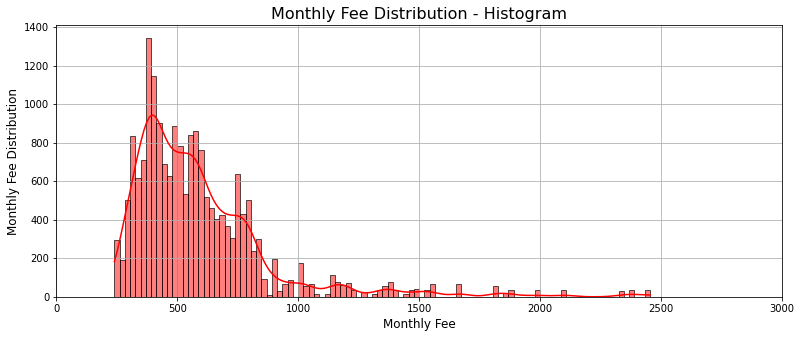

In [13]:
# Histogram
hist_color = 'red'
title_font_size = 16
label_font_size = 12
plt.figure(figsize=(13,5))
sns.histplot(TARGET['fee'], kde=True, color=hist_color)
plt.title('Monthly Fee Distribution - Histogram', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.xticks(ticks=plt.xticks()[0][::1])  
plt.ylabel('Monthly Fee Distribution', fontsize=label_font_size)
plt.grid(True)
plt.show()

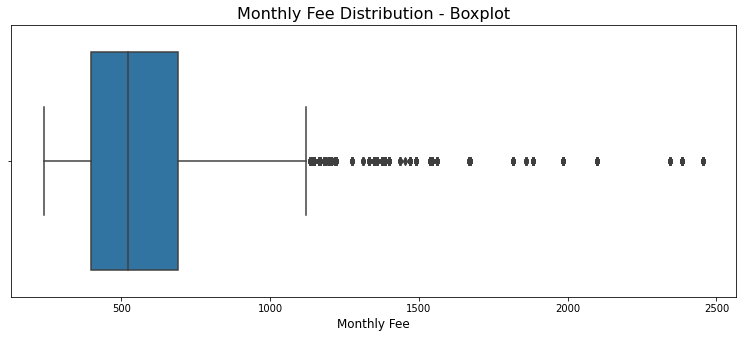

In [14]:
# Boxplot
plt.figure(figsize=(13,5))
sns.boxplot(x=df['fee'])
plt.title('Monthly Fee Distribution - Boxplot', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.show()

### Numerical Feature Variables

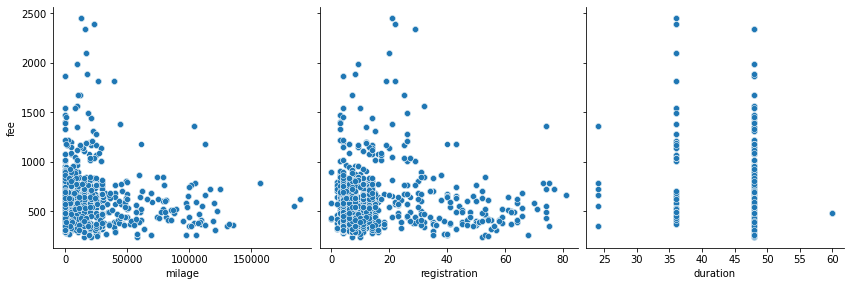

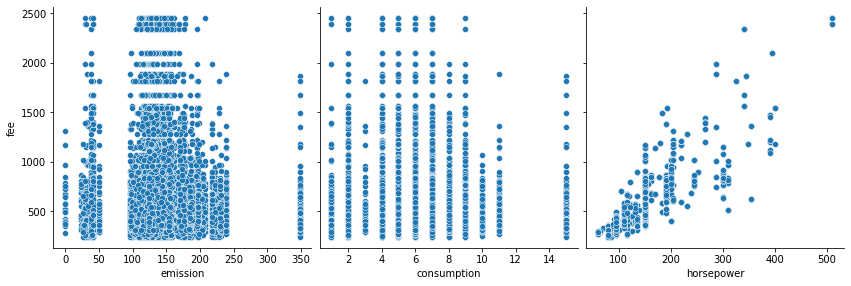

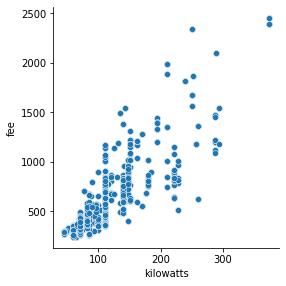

In [15]:
def pp(x,y,z):
    sns.pairplot(df, x_vars=[x,y,z], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('milage', 'registration', 'duration')
pp('emission', 'consumption', 'horsepower')

def pp(x):
    sns.pairplot(df, x_vars=[x], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('kilowatts')

#### Skewness of numerical variables



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

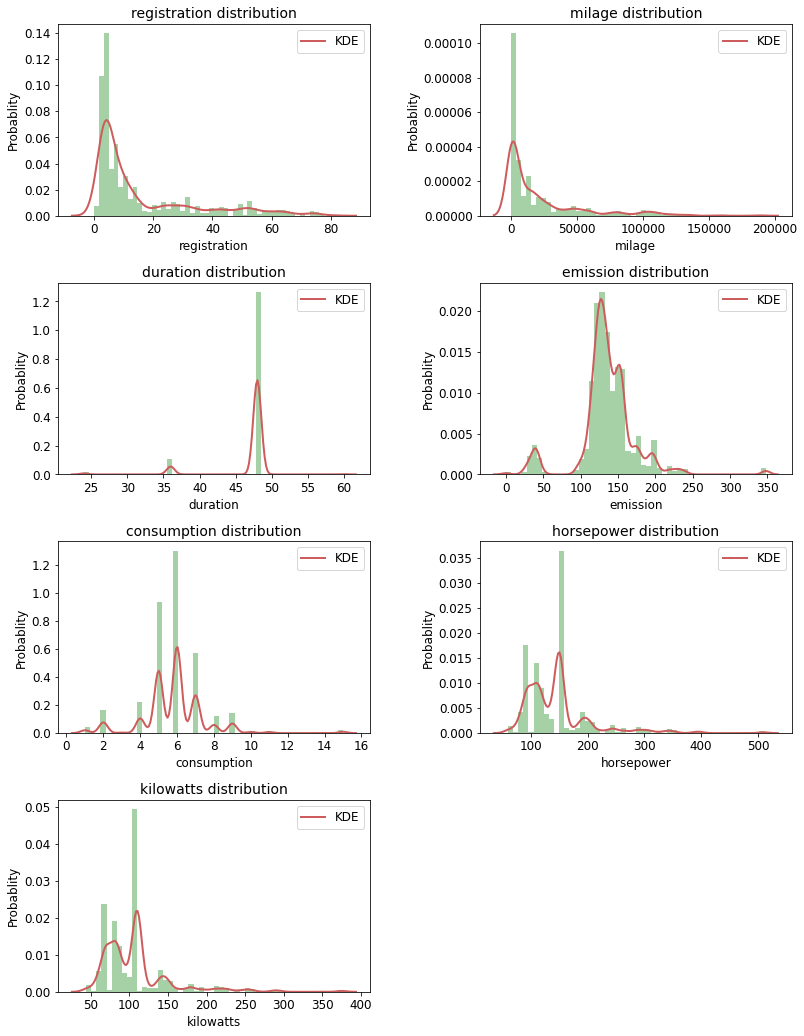

In [16]:
num_FEATURES_hist = num_FEATURES.dropna()

plt.figure(figsize=(12,16))

for i, col in enumerate(num_FEATURES_hist.columns):
    # TAKE A LOOK AT THE IDX VARIABLE!!!!!!
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.distplot(num_FEATURES_hist[col], color='forestgreen', kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()

### Categporical Feature Variables

In [17]:
cat_FEATURES

,brand,model,gear,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,Automatik,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
19056,Volkswagen,Polo VW,Manuelle Schaltung,Benzin


Text(0.5, 1.0, 'Gear Frequencies')

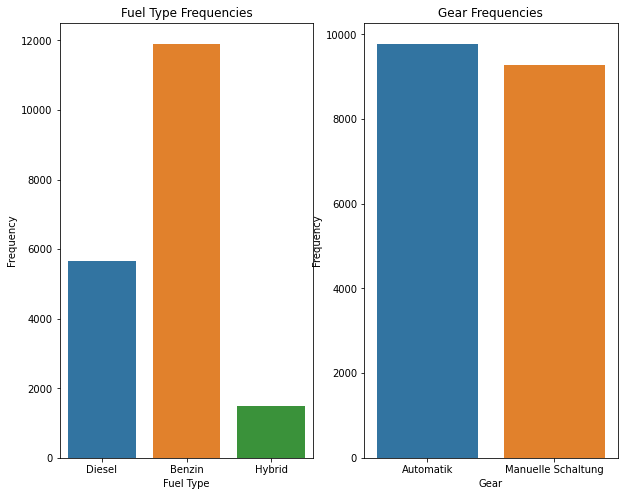

In [18]:
# Create subplots for each categorical variable

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 8))

# Fuel type barplot
sns.countplot(x='fuel', data=cat_FEATURES, ax=axs[0])
axs[0].set_xlabel('Fuel Type')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Fuel Type Frequencies')

# Gear barplot
sns.countplot(x='gear', data=cat_FEATURES, ax=axs[1])
axs[1].set_xlabel('Gear')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Gear Frequencies')

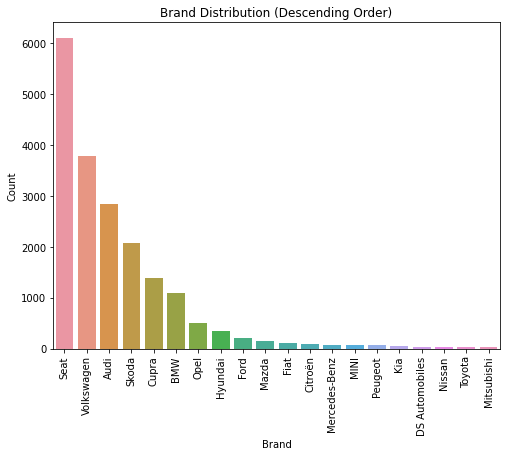

In [19]:

# Assuming your DataFrame is called 'df'
brand_counts = df['brand'].value_counts()

# Sort the brand counts in descending order
brand_counts = brand_counts.sort_values(ascending=False)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='brand', order=brand_counts.index)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Brand Distribution (Descending Order)')
plt.xticks(rotation=90)
plt.show()




In [20]:
## SINA SCHAUST GUCKST

# plt.figure(figsize=(25, 6))

# df_brand = pd.DataFrame(df.groupby(['brand'])['fee'].mean().sort_values(ascending = False))
# df_brand.plot.bar()
# plt.title('Monthly fee vs brand_name')
# plt.show()

# df_fueltype = pd.DataFrame(df.groupby(['fuel'])['fee'].mean().sort_values(ascending = False))
# df_fueltype.plot.bar()
# plt.title('Fuel Type vs Average Price')
# plt.show()

# df_gear = pd.DataFrame(df.groupby(['gear'])['fee'].mean().sort_values(ascending = False))
# df_gear.plot.bar()
# plt.title('gear vs Average Price')
# plt.show()

### Heatmap (Correlations)

In [21]:
num_FEATURES

,registration,milage,duration,emission,consumption,horsepower,kilowatts
0,2,201.0,48.0,119.0,5.0,150.0,110.0
1,2,201.0,48.0,131.0,6.0,95.0,70.0
2,7,15000.0,48.0,120.0,5.0,80.0,59.0
3,4,1.0,48.0,127.0,6.0,80.0,59.0
4,41,105301.0,48.0,138.0,5.0,190.0,140.0
...,...,...,...,...,...,...,...
19053,4,201.0,48.0,146.0,6.0,150.0,110.0
19054,2,201.0,48.0,187.0,8.0,150.0,110.0
19055,41,105301.0,48.0,143.0,6.0,190.0,140.0
19056,35,18903.0,48.0,40.0,2.0,80.0,59.0


In [22]:
##SINA MACHEN!!###

# setting figure size
# plt.figure(figsize=(10,7))
# df_corr=df.drop(cat_FEATURES.columns).corr()

# heatmap
# sns.heatmap(num_FEATURES_corr, annot=True, linewidths=1.01, fmt = ".2f", annot_kws={"size": 12}, linecolor='white', cmap="YlGnBu")

# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.savefig('correaltion_heatmap.png', dpi = 100, bbox_inches="tight")
# plt.show()

---

## Preprocessing and Feature Engineering

### Missing Values


In [23]:
missing_values = df.isnull().sum()

print("Summary of Missing Values:")
print(missing_values)

Summary of Missing Values:
registration      0
milage            0
duration          0
fee               0
emission        612
consumption     612
horsepower        0
kilowatts         0
brand             0
model             0
gear              0
fuel              0
dtype: int64


### Cardinality of non-numeric features

In [24]:
unique_counts = cat_FEATURES.nunique()
print(unique_counts)

brand     20
model    346
gear       2
fuel       3
dtype: int64


### Problems with splitting

When splitting the dataset by using "train_test_split" we need to use stratification so that one-hot encoding works.
This creates the problem, that entries of the model column, that exist only once OR Twice can not be splitted using stratify. We have three possible approaches:
- drop once or twice appearing single entries of "model"
- duplicate or tripple once or twice appreaing entries of "model"
- create combined category for those models
- **use a custom splitting algorithm**

for now we desided to drop those entries -> Do other approach later!!!!

In [25]:
old_shape = df.shape[0]

In [26]:
few_instances_model = df.groupby("model").filter(lambda x: len(x) < 3)["model"].unique()
df=df[~df["model"].isin(few_instances_model)]
df.shape
print("Models dropped:", old_shape-df.shape[0])

Models dropped: 19


### Out of Sample Dataset

In [27]:
df_sample, df_osample = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df[["model"]])

In [28]:
print("Size of the sample data:",df_sample.shape, "with a mean of: ",df_sample["fee"].mean(),
    "\nSize of out of sample data:",df_osample.shape, "with a mean of: ",df_osample["fee"].mean())

Size of the sample data: (16183, 12) with a mean of:  593.0066569857258 
Size of out of sample data: (2856, 12) with a mean of:  592.3941316526611


### Train and Test slpit

In [29]:
X_sample = df_sample.drop(TARGET_name,axis=1)
Y_sample = df_sample[TARGET_name]

X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.25, random_state=SEED, stratify=X_sample[["model"]])
print("Size of the train data:",X_train.shape,"with a mean fee of:",y_train.mean())
print("Size of the test data:",X_train.shape,"with a mean fee of:",y_test.mean())

Size of the train data: (12137, 11) with a mean fee of: 593.1457435939689
Size of the test data: (12137, 11) with a mean fee of: 592.5894315373208


### Transformer Pipelines

In [30]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES.columns

In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error', sparse_output=False, drop = 'first'))])

preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

preprocessor.fit(X_train)

cat_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
columns_pipeline = np.append(cat_columns, numeric_features)

## Machine Learning Modeling

### Choosing appropriate metric & customization approach

For evaluation we chose a number of measurements:
- MSE: Mean-Square-Error
- RMSE: Root-Mean-Square-Error (for easier interpretation)
- R-squared (R²)
- Adjusted R-squared
- MAPE: Mean Absolute Percentage Error
- EVS: Explained variance score

In [32]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

def evaluate(model, X, Y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(Y, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    evs = explained_variance_score(Y, y_pred)
    mapr = mean_absolute_percentage_error(Y, y_pred)

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "EVS": evs,
        "MAPE": mapr
    }
    return (metrics)

# Scoring dictionary
scoring1 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}
scoring2 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}
scoring3 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

### Desicion Tree

In [33]:
from scipy.stats import uniform
# Define the parameter distribution
param_dist = {
    #'regressor__max_depth': randint(1, 10), # increasing depth always increases score -> overfitting
    'regressor__min_samples_split': randint(2, 30),
    'regressor__min_samples_leaf': randint(1, 70),
    'regressor__ccp_alpha': uniform(0, 0.05) # search for best ccp_alpha
}

# Create a new pipeline with the decision tree regression model
decisionTree_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    # Decision tree regression model
    ("regressor", DecisionTreeRegressor())
])

# Perform randomized search with cross-validation
decisionTree_randomized_search = RandomizedSearchCV(
                                            decisionTree_pipeline, 
                                            param_dist, 
                                            n_iter=30, 
                                            cv=10, 
                                            scoring=scoring3, 
                                            refit='MSE', 
                                            random_state=SEED, 
                                            n_jobs = -1)
decisionTree_randomized_search.fit(X_train, y_train)

# evaluation metrics
train_metrics = evaluate(decisionTree_randomized_search, X_train, y_train)
test_metrics = evaluate(decisionTree_randomized_search, X_test, y_test)

# create a dataframe from metrics
decisionTree_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(decisionTree_rand_metrics)

# Get the best hyperparameter values and model performance
best_params = decisionTree_randomized_search.best_params_

decisionTree_params = pd.DataFrame({"Parameters": best_params})
print(decisionTree_params)




Evaluation Metrics:
      Train Set    Test Set
MSE   79.107363  118.475616
RMSE   8.894232   10.884650
MAE    3.189123    3.763099
R2     0.999144    0.998723
EVS    0.999144    0.998724
MAPE   0.006018    0.007153
                              Parameters
regressor__ccp_alpha            0.034931
regressor__min_samples_leaf     6.000000
regressor__min_samples_split   17.000000


In [34]:
finalTree = DecisionTreeRegressor(
    ccp_alpha = best_params['regressor__ccp_alpha'],
    min_samples_leaf = best_params['regressor__min_samples_leaf'],
    min_samples_split = best_params['regressor__min_samples_split']
)

decisionTree_final = Pipeline([
    ("preprocessor", preprocessor),
    # Decision tree regression model
    ("regressor", finalTree)
])
decisionTree_final.fit(X_train, y_train)

train_metrics = evaluate(decisionTree_final, X_train, y_train)
test_metrics = evaluate(decisionTree_final, X_test, y_test)

# create a dataframe from metrics
decisionTree_metrics = pd.DataFrame({'Train Set':train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(decisionTree_metrics)


Evaluation Metrics:
      Train Set    Test Set
MSE   79.107363  118.406610
RMSE   8.894232   10.881480
MAE    3.189123    3.774878
R2     0.999144    0.998723
EVS    0.999144    0.998725
MAPE   0.006018    0.007179


### Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

param_dist = {
    'regressor__n_estimators': randint(20,50),
    # 'regressor__max_depth': randint(1,7),
    'regressor__min_samples_split': randint(2, 30),
    'regressor__min_samples_leaf': randint(1, 100),
    'regressor__random_state': [SEED],
    'regressor__n_jobs':[-1]
}

rf_randomized_search = RandomizedSearchCV(
                                        rf_pipeline, 
                                        param_distributions=param_dist, 
                                        n_iter = 30, 
                                        cv=10,
                                        scoring=scoring3,
                                        refit='MSE',
                                        return_train_score=True,
                                        n_jobs = -1)

rf_randomized_search.fit(X_train, y_train)

# evaluation metrics
train_metrics = evaluate(rf_randomized_search, X_train, y_train)
test_metrics = evaluate(rf_randomized_search, X_test, y_test)

# create a dataframe from metrics
randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_rand_metrics)

# Get the best hyperparameter values and model performance
best_params = rf_randomized_search.best_params_

randomForest_params = pd.DataFrame({"Parameters": best_params})
print(randomForest_params)




Evaluation Metrics:
      Train Set   Test Set
MSE   26.287255  60.855083
RMSE   5.127110   7.800967
MAE    1.751839   2.668982
R2     0.999716   0.999344
EVS    0.999716   0.999345
MAPE   0.003356   0.005195
                              Parameters
regressor__min_samples_leaf            1
regressor__min_samples_split           7
regressor__n_estimators               79
regressor__n_jobs                     -1
regressor__random_state             2023


In [34]:
finalForest = RandomForestRegressor(
    n_estimators = best_params['regressor__n_estimators'],
    min_samples_split = best_params['regressor__min_samples_split'],
    min_samples_leaf = best_params['regressor__min_samples_leaf'],
    n_jobs =best_params['regressor__n_jobs'],
    random_state = best_params['regressor__random_state']
)

randomForest_final = Pipeline([
    ("preprocessor", preprocessor),
    # Decision tree regression model
    ("regressor", finalForest)
])
randomForest_final.fit(X_train, y_train)

train_metrics = evaluate(randomForest_final, X_train, y_train)
test_metrics = evaluate(randomForest_final, X_test, y_test)

# create a dataframe from metrics
randomForest_metrics = pd.DataFrame({'Train Set':train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_metrics)


Evaluation Metrics:
      Train Set   Test Set
MSE   26.287255  60.855083
RMSE   5.127110   7.800967
MAE    1.751839   2.668982
R2     0.999716   0.999344
EVS    0.999716   0.999345
MAPE   0.003356   0.005195


### K-nearest neighbor

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pandas as pd

# Define the KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# Define the parameter distribution for random search
param_dist = {
    'regressor__n_neighbors': randint(1, 10),
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
    'regressor__n_jobs':[-1]
}

# Perform random search for hyperparameter tuning
knn_randomized_search = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scoring3,
    refit='MSE',
    return_train_score=True,
    random_state = SEED,
    n_jobs = -1
)

# Fit the KNN model to the training data
knn_randomized_search.fit(X_train, y_train)

# Evaluate the model performance
train_metrics = evaluate(knn_randomized_search, X_train, y_train)
test_metrics = evaluate(knn_randomized_search, X_test, y_test)

# Create a dataframe from metrics
knn_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(knn_metrics)

# Get the best hyperparameter values and model performance
best_params = knn_randomized_search.best_params_
knn_params = pd.DataFrame({"Parameters": best_params})
print(knn_params)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['registration', 'milage', 'duration', 'emission', 'consumption',
       'horsepower', 'kilowatts'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImpu...
                                        'regressor__p': [1, 2],
                                        'regressor__weights': ['uniform',
                                                               'distance']},
                   random_state=2023, refit='MSE', return_train_score=True,
                   scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                            'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                            'MSE': make_scorer(mean_squared_error, greater_is_better=False),
                            'R2': make_scorer(r2_score)})

In [40]:
finalKnn = KNeighborsRegressor(
    n_neighbors = best_params['regressor__n_neighbors'],
    weights= best_params['regressor__weights'],
    p = best_params['regressor__p']
)

knn_final = Pipeline([
    ("preprocessor", preprocessor),
    # Decision tree regression model
    ("regressor", finalKnn)
])

knn_final.fit(X_train, y_train)

train_metrics = evaluate(knn_final, X_train, y_train)
test_metrics = evaluate(knn_final, X_test, y_test)

# create a dataframe from metrics
knn_metrics = pd.DataFrame({'Train Set':train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(knn_metrics)


Evaluation Metrics:
      Train Set    Test Set
MSE   12.584982  439.484082
RMSE   3.547532   20.963876
MAE    0.714233    7.406270
R2     0.999864    0.995262
EVS    0.999864    0.995265
MAPE   0.001399    0.013681


### XGB

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'regressor__max_depth': randint(1, 7),
    'regressor__learning_rate': [0.1, 0.01, 0.001],
    'regressor__n_estimators': randint(100, 1000),
    'regressor__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'regressor__subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0],
}

# Create a new pipeline with the XGBoost regressor model
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor())
])

# Perform randomized search with cross-validation
xgb_randomized_search = RandomizedSearchCV(
    xgb_pipeline,
    param_dist,
    n_iter=30,
    cv=5,
    scoring=scoring3,
    refit='MSE',
    return_train_score=True,
    n_jobs=-1)
    
xgb_randomized_search.fit(X_train, y_train)

y_test_pred_xgb = xgb_randomized_search.predict(X_test)

# Evaluation metrics
mse_XGB = mean_squared_error(y_test, y_test_pred_xgb)
mae_XGB = mean_absolute_error(y_test, y_test_pred_xgb)
r2_XGB = r2_score(y_test, y_test_pred_xgb)

print("MSE: ", mse_XGB)
print("MAE: ", mae_XGB)
print("R2: ", r2_XGB)

# Get the best hyperparameter values and model performance
best_params = xgb_randomized_search.best_params_


### Support-Vector-Machines (SVM)

In [41]:
from sklearn.svm import SVR

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

param_dist = {
    'regressor__C': [0.01, 0.1, 0.5, 1, 10],
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__epsilon': [0.1, 0.2, 0.3],
}
svm_randomized_search = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scoring3,
    refit='MSE',
    return_train_score=True,
    n_jobs=-1
)

svm_randomized_search.fit(X_train, y_train)

# Evaluation metrics
train_metrics = evaluate(svm_randomized_search, X_train, y_train)
test_metrics = evaluate(svm_randomized_search, X_test, y_test)

# Create a DataFrame from metrics
svm_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(svm_rand_metrics)

# Get the best hyperparameter values and model performance
best_params = svm_randomized_search.best_params_
svm_params = pd.DataFrame({"Parameters": best_params})
print(svm_params)

KeyboardInterrupt: 

In [ ]:
finalSVM = SVR(
    C=best_params['regressor__C'],
    kernel=best_params['regressor__kernel'],
    gamma=best_params['regressor__gamma'],
    epsilon=best_params['regressor__epsilon']
)

svm_final = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", finalSVM)
])
svm_final.fit(X_train, y_train)

train_metrics = evaluate(svm_final, X_train, y_train)
test_metrics = evaluate(svm_final, X_test, y_test)

# Create a DataFrame from metrics
svm_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

print("\nEvaluation Metrics:")
print(svm_metrics)


## Performance on Test Dataset

### Metrics Plots - Still to do!!!

In [64]:
decisionTree_metrics['Model'] = 'Decision Tree'
randomForest_metrics['Model'] = 'Random Forest'
knn_metrics['Model'] = 'KNN'
df = pd.concat([decisionTree_metrics, randomForest_metrics, knn_metrics])

df

#svm_metrics
#xgb_metrics

,Train Set,Test Set,Model
MSE,79.107363,117.686935,Decision Tree
RMSE,8.894232,10.848361,Decision Tree
MAE,3.189123,3.760801,Decision Tree
R2,0.999144,0.998731,Decision Tree
EVS,0.999144,0.998732,Decision Tree
MAPE,0.006018,0.007151,Decision Tree
MSE,26.287255,60.855083,Random Forest
RMSE,5.127110,7.800967,Random Forest
MAE,1.751839,2.668982,Random Forest
R2,0.999716,0.999344,Random Forest


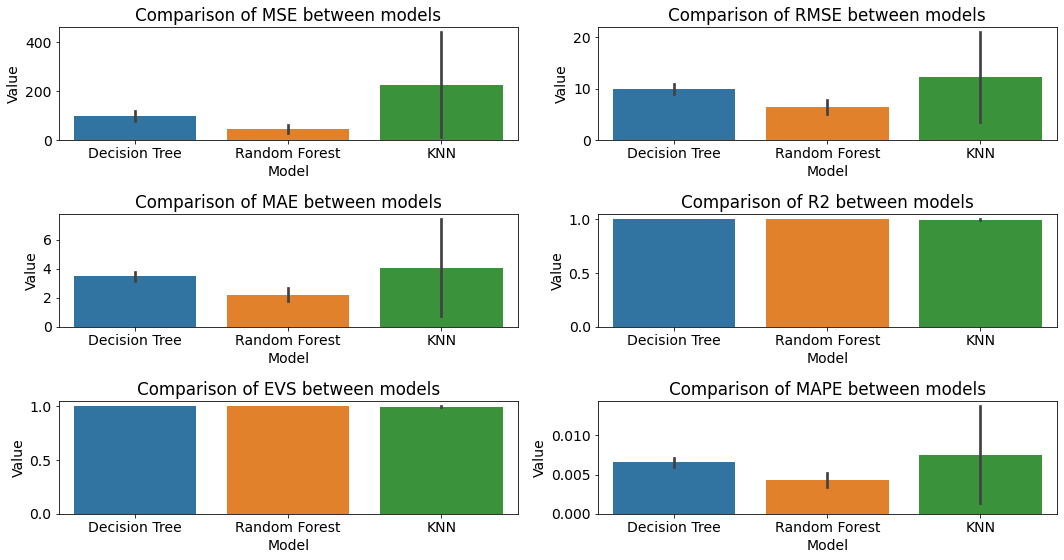

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Concatenate dataframes and add model names as a column
decisionTree_metrics['Model'] = 'Decision Tree'
randomForest_metrics['Model'] = 'Random Forest'
knn_metrics['Model'] = 'KNN'
df = pd.concat([decisionTree_metrics, randomForest_metrics, knn_metrics])

# Convert dataframe to long format
df_long = df.reset_index().melt(id_vars=['Model', 'index'])

# List of metrics
metrics = df_long['index'].unique()

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=len(metrics)//2, figsize=(15, 8))
axs = axs.flatten()

# Plot a bar plot for each metric
for i, metric in enumerate(metrics):
    data = df_long[df_long['index'] == metric]
    ax = axs[i]
    sns.barplot(x='Model', y='value', data=data, ax=ax)
    ax.set_title(f'Comparison of {metric} between models')
    ax.set_ylabel('Value')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Predicted vs actual plots
This is a scatter plot where the x-axis is the actual target values and the y-axis is the predicted values. If your model is perfectly accurate, all the points will lie along the line y = x (a 45-degree line). Deviations from this line indicate errors in prediction.

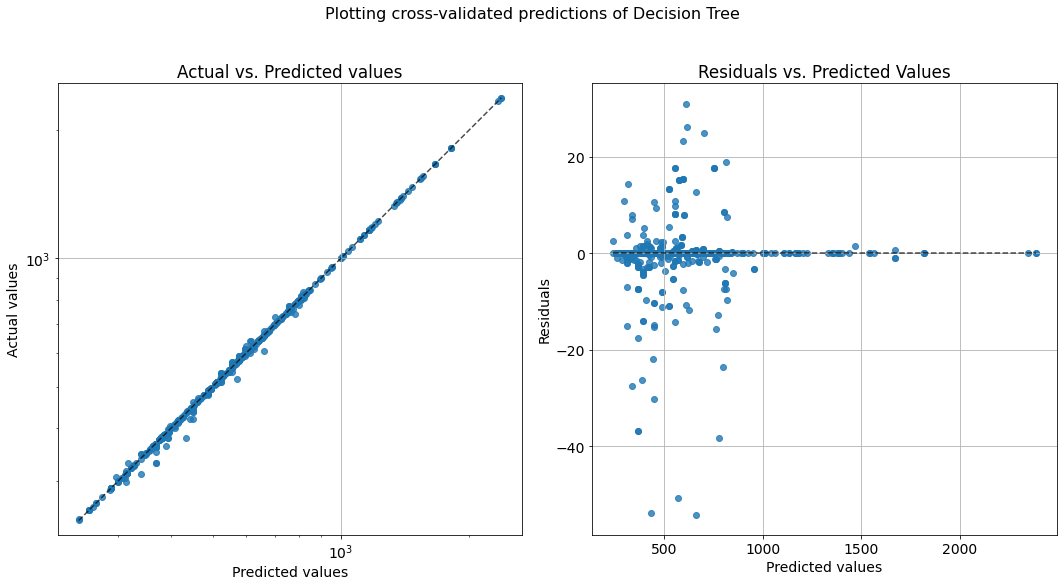

The mean residual of Decision Tree is: 0.3340269742171282


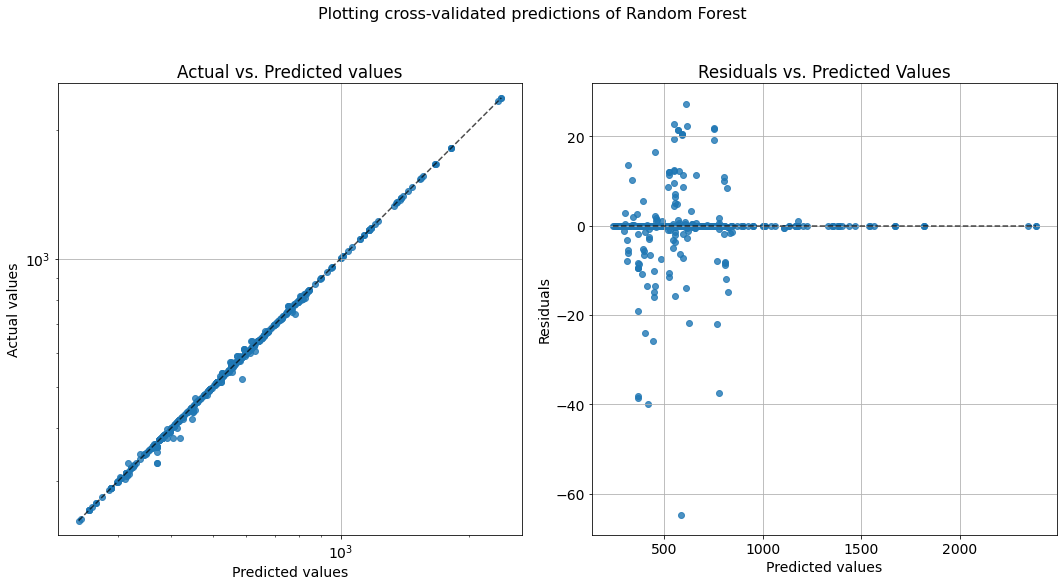

The mean residual of Random Forest is: 0.34579884419989754


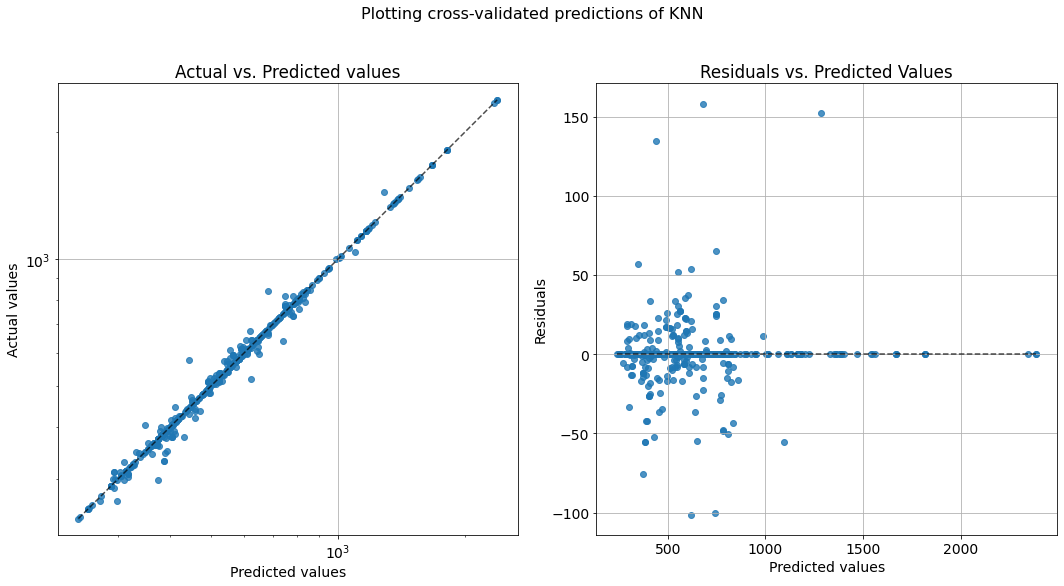

The mean residual of KNN is: 0.5624362592060149


In [54]:
def plotPvA(model, name, X, y):
    y_pred = model.predict(X)
    fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

    # Increase default font size
    plt.rcParams.update({'font.size': 14})

    # Define the prediction error display for actual vs. predicted
    pred_err_disp1 = PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[0].grid(True)
    axs[0].set_xlabel('Predicted values')
    axs[0].set_ylabel('Actual values')
    axs[0].set_title("Actual vs. Predicted values")

    # Set the axis scale to log
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # Define the prediction error display for residuals vs. predicted
    pred_err_disp2 = PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[1].grid(True)
    axs[1].set_xlabel('Predicted values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title("Residuals vs. Predicted Values")


    # Set the main title and layout
    fig.suptitle(f"Plotting cross-validated predictions of {name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    residuals = (y - y_pred)
    print(f"The mean residual of {name} is:", np.mean(residuals))

plotPvA(decisionTree_final, "Decision Tree", X_test, y_test)
plotPvA(randomForest_final, "Random Forest", X_test, y_test)
plotPvA(knn_final, "KNN", X_test, y_test)

### Histogram of residuals - Still to do!
This plot can be used to check if the residuals are normally distributed, which is an assumption of many regression models. If the residuals are not normally distributed, it suggests that your model is not correctly capturing the data's patterns.

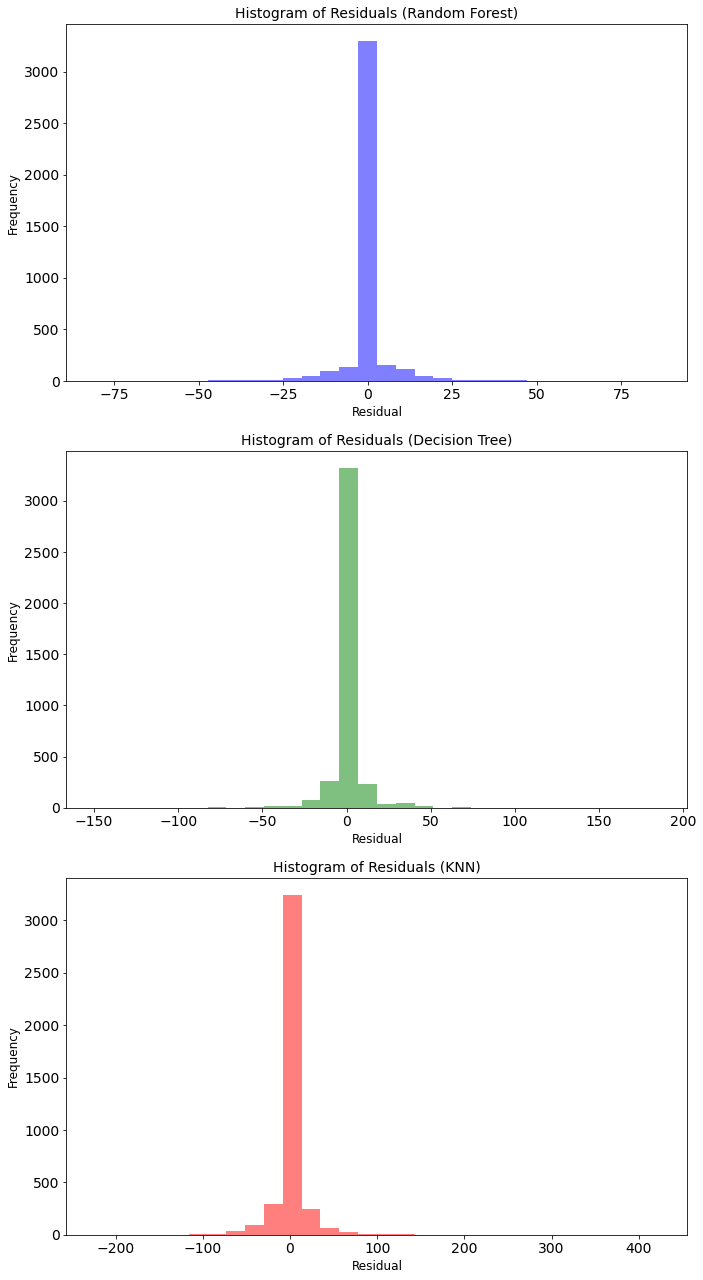

In [63]:
# Obtain the predictions of the models
y_pred_rf = randomForest_final.predict(X_test)
y_pred_dt = decisionTree_final.predict(X_test)
y_pred_knn = knn_final.predict(X_test)

# Compute the residuals
residuals_rf = y_test - y_pred_rf
residuals_dt = y_test - y_pred_dt
residuals_knn = y_test - y_pred_knn

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Create a histogram of the residuals for Random Forest
axs[0].hist(residuals_rf, bins=30, color='blue', alpha=0.5)
axs[0].set_title('Histogram of Residuals (Random Forest)', fontsize=14)
axs[0].set_xlabel('Residual', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)

# Create a histogram of the residuals for Decision Tree
axs[1].hist(residuals_dt, bins=30, color='green', alpha=0.5)
axs[1].set_title('Histogram of Residuals (Decision Tree)', fontsize=14)
axs[1].set_xlabel('Residual', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)

# Create a histogram of the residuals for KNN
axs[2].hist(residuals_knn, bins=30, color='red', alpha=0.5)
axs[2].set_title('Histogram of Residuals (KNN)', fontsize=14)
axs[2].set_xlabel('Residual', fontsize=12)
axs[2].set_ylabel('Frequency', fontsize=12)

# Improve layout
fig.tight_layout()
plt.show()


## Performance on out of sample Dataset

### Metrics

### Predicted vs actual plots
This is a scatter plot where the x-axis is the actual target values and the y-axis is the predicted values. If your model is perfectly accurate, all the points will lie along the line y = x (a 45-degree line). Deviations from this line indicate errors in prediction.

### Histogram of residuals - Still to do!
This plot can be used to check if the residuals are normally distributed, which is an assumption of many regression models. If the residuals are not normally distributed, it suggests that your model is not correctly capturing the data's patterns.

## Feature Importance Analysis

In [68]:
!pip install --upgrade numba


     |████████████████████████████████| 2.5 MB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 30.4 MB 33.8 MB/s eta 0:00:01
  Using cached numpy-1.24.3-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [66]:
!pip install shap

     |████████████████████████████████| 436 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 16.1 MB 252 kB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.


In [41]:
!pip install --upgrade shap

In [42]:
import shap

# https://www.kaggle.com/kritidoneria/responsible-ai-model-explainability/data
explainer = shap.TreeExplainer(decisionTree_final.named_steps["regressor"])
observations = decisionTree_final.named_steps["preprocessor"].transform(X_train)
shap_values = explainer.shap_values(observations)
shap.initjs()

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
shap.summary_plot(shap_values, features=observations, feature_names=list(columns_pipeline), show = False)
# plt.savefig("shap.png", format='png', dpi=1000, bbox_inches='tight')
plt.show()

## Check assumptions - Still to do
Now, let's talk about the assumptions of a regression model. The common ones are:

Linearity: The relationship between the independent and dependent variable is linear. This can be checked with a scatter plot of each independent variable vs the dependent variable.

Independence: The residuals are independent. In particular, there is no correlation between consecutive residuals (in time series data). This is often checked using a Durbin-Watson test.

Homoscedasticity: The variance of residuals is the same for all levels of the independent variables. This means that the model's errors are equally variable across all independent variables. This can be checked with a plot of residuals (or standardized residuals) vs. predicted (or fitted) values.

Normality of residuals: For any fixed value of the independent variable, the dependent variable is normally distributed. This can be checked with a Q-Q plot or a histogram of the residuals.


## Check Scikit-learn and python version

In [36]:
import sklearn
sklearn.__version__
if(sklearn.__version__!="1.2.2"):
    try:
        !pip install --upgrade numpy
        !pip install --upgrade pandas
        !pip install --upgrade scikit-learn
    except:
        print("Check your Python version. Has to be >3.8!")
        import sys
        print(sys.version)
